# 1. The Thompson Sampling Algorithm

Thompson sampling is an algorithm for online decision problems where actions are taken sequentially in a manner that must balance between exploiting what is known to maximize immediate performance and investing to accumulate new information that may improve future performance. The colorful name for our problem comes from a motivating story in which a gambler enters a casino and sits down at a slot machine with multiple levers, or arms, that can be pulled. When pulled, an arm produces a random payout drawn independently of the past. Because the distribution of payouts corresponding to each arm is not listed, the player can learn it only by experimenting. As the gambler learns about the arms’ payouts, she faces a dilemma: in the immediate future she expects to earn more by exploiting arms that yielded high payouts in the past, but by continuing to explore alternative arms she may learn how to earn higher payouts in the future. Can she develop a sequential strategy for pulling arms that balances this tradeoff and maximizes the cumulative payout earned?

Suppose the agent applies a sequence of actions $x_1,x_2,x_3,...$ to a system, selecting each from a set $X$. After applying action $x_t$, the agent observes an outcome $y_t$, which the system randomly generates according to a conditional probability measure $q_θ(·|x_t)$. The agent enjoys a reward $r_t = r(y_t)$, where $r$ is a known function. The agent is initially uncertain about the value of $θ$ and represents his uncertainty using a prior distribution $p$.

**Algorithm** - $\text{Thompson}(X,p,q,r)$ <br>
1: **for** $t = 1,2,...$ **do** <br> 
2: $\space$ $\space$ # sample model: <br>
3: $\space$ $\space$ Sample $\hat{θ} ∼ p$ <br>
4: <br>
5: $\space$ $\space$ #select and apply action: <br>
6: $\space$ $\space$ $x_t ← \text{argmax}_{x \in X} E_{q_θ}[r(y_t)|x_t = x]$ <br>
7: $\space$ $\space$ Apply $x_t$ and observe $y_t$ <br>
8: $\space$ $\space$ <br>
9: $\space$ $\space$ # update distribution: <br>
10: $\space$ $\space$ $p ← P_{p,q}(θ \in ·| x_t, y_t)$ <br>
11: **end for**

The Bernoulli bandit with a beta prior serves as a special case of this more general formulation. In this special case, the set of actions is $X ={1,...,K}$ and only rewards are observed, so $y_t = r_t$. Observations and rewards are modeled by conditional probabilities $q_θ(1|k) = θ_k$ and $q_θ(0|k) = 1 −θ_k$. 

The prior distribution is encoded by vectors $α$ and $β$, with probability density function given by:

$$
p_\theta = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha_k) \Gamma(\beta_k)} \theta_{k}^{a_k - 1} (1 - \theta_k)^{\beta_k - 1}
$$

where $\Gamma$ denotes the gamma function. In other words, under the prior distribution, components of $θ$ are independent and beta-distributed, with parameters $α$ and $β$.

For this problem, the TS begins each $t$-th iteration with posterior parameters $(α_k,β_k)$ for $k ∈ {1,...,K}$. It randomly draws $\hat{θ}_k$ from a beta distribution with parameters $(α_k,β_k)$ and then selects the action $x$ that maximizes $E_{q_θ} [r(y_t)|x_t = x] = \hat{θ}_k$. After applying the selected action, a reward $r_t = y_t$ is observed, and belief distribution parameters are updated according to:
$$
(α,β) ← (α + r_t 1_{x_t} ,β + (1 − r_t)1_{x_t} )
$$

where $1_{x_t}$ is a vector with component $x_t$ equal to $1$ and all other components equal to $0$.

# 2. Modelling Considerations

Our discussions above has centered around a somewhat idealised view of TS, which ignored the process of prior specification and assumed a simple model in which the system and set of feasible actions is constant over time and there is no side information on decision context.

Therefore, in the following sections we will focus on the decision of the prior distribution

## 2.1. Prior Distribution Specification

The TS algorithm we have presented require as input a **prior distribution** over model parameters. The choice of prior can be important so let's think of a banner ad placement problem.

There are $K$ banner ads for a single product, with unknown click-through probabilities $(θ_1, . . . ,θ_K)$. Given a prior, TS can learn to select the most successful ad. We could use a uniform or, equivalently, a $Beta(1,1)$ distribution over each $θ_k$. However, if some values of θk are more likely than others, using a uniform prior sacrifices performance. In particular, this prior represents no understanding of the context, ignoring any useful knowledge from past experience. Taking knowledge into account reduces what must be learned and therefore reduces the time it takes for TS to identify the most effective ads.

**Example**

Suppose we have a data set collected from experience with previous products and their ads, each distinguished by stylistic features such as language, font, and background, together with accurate estimates of click-through probabilities. Let us consider an empirical approach to prior selection that leverages this data.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import beta

# Set random seed for reproducibility
np.random.seed(42)

# Number of data points per partition
n_ads_per_partition = 100

# Extend the dataset to include additional features like Language, Font, and Background
languages = ["English", "French", "Spanish"]
fonts = ["Arial", "Times New Roman", "Verdana"]
backgrounds = ["Blue", "Yellow", "Green"]

# Create a complete dataset
full_partition_data = {
    "Ad_ID": [],
    "Partition": [],
    "Language": [],
    "Font": [],
    "Background": [],
    "Impressions": [],
    "Clicks": [],
    "CTR": []
}

# Generate synthetic data for each partition
for partition, (a, b) in enumerate([(1, 50), (1, 100), (1, 200)], start=1):
    ctrs = beta.rvs(a, b, size=n_ads_per_partition)  # Generate CTRs from Beta distribution
    impressions = np.random.randint(500, 2000, size=n_ads_per_partition)
    clicks = (ctrs * impressions).astype(int)  # Compute clicks as CTR * impressions
    
    for i in range(n_ads_per_partition):
        full_partition_data["Ad_ID"].append(f"Ad_{partition}_{i+1}")
        full_partition_data["Partition"].append(partition)
        full_partition_data["Language"].append(languages[partition - 1])
        full_partition_data["Font"].append(fonts[partition - 1])
        full_partition_data["Background"].append(backgrounds[partition - 1])
        full_partition_data["Impressions"].append(impressions[i])
        full_partition_data["Clicks"].append(clicks[i])
        full_partition_data["CTR"].append(ctrs[i])

# Create a DataFrame with the full dataset
full_distinct_ecdf_df = pd.DataFrame(full_partition_data)

# Display the dataset
print(full_distinct_ecdf_df.head())


    Ad_ID  Partition Language   Font Background  Impressions  Clicks       CTR
0  Ad_1_1          1  English  Arial       Blue         1196      13  0.010989
1  Ad_1_2          1  English  Arial       Blue         1808       2  0.001151
2  Ad_1_3          1  English  Arial       Blue         1743      34  0.019721
3  Ad_1_4          1  English  Arial       Blue         1592      12  0.007815
4  Ad_1_5          1  English  Arial       Blue         1570      15  0.010061


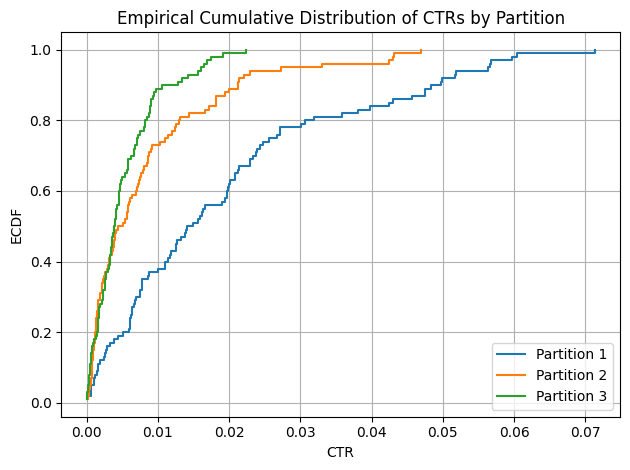

In [3]:
import matplotlib.pyplot as plt

# Function to compute ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of data."""
    sorted_data = np.sort(data)
    ecdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ecdf_values

# Plot ECDF for each partition
for partition in full_distinct_ecdf_df["Partition"].unique():
    # Filter data for the current partition
    partition_data = full_distinct_ecdf_df[full_distinct_ecdf_df["Partition"] == partition]
    
    # Extract CTR values for the current partition
    ctr_values = partition_data["CTR"].values
    
    # Compute ECDF
    x, y = ecdf(ctr_values)
    
    # Plot ECDF
    plt.step(x, y, where="post", label=f"Partition {int(partition)}")

# Customize plot
plt.title("Empirical Cumulative Distribution of CTRs by Partition")
plt.xlabel("CTR")
plt.ylabel("ECDF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

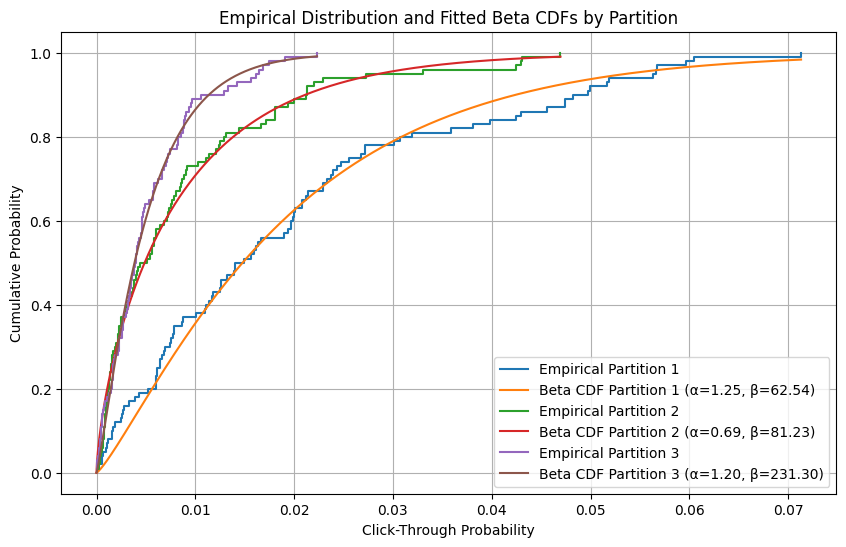

In [4]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

# Function to fit a Beta distribution to data
def fit_beta(data):
    """
    Fits a Beta distribution to the data by estimating alpha and beta parameters.
    """
    mean = np.mean(data)
    var = np.var(data)
    # Beta distribution parameters
    alpha = mean * ((mean * (1 - mean)) / var - 1)
    beta_param = (1 - mean) * ((mean * (1 - mean)) / var - 1)
    return alpha, beta_param

# Plot ECDF and Beta CDF for each partition
plt.figure(figsize=(10, 6))

for partition in full_distinct_ecdf_df["Partition"].unique():
    # Filter data for the current partition
    partition_data = full_distinct_ecdf_df[full_distinct_ecdf_df["Partition"] == partition]
    
    # Extract CTR values for the current partition
    ctr_values = partition_data["CTR"].values
    
    # Compute ECDF
    sorted_data = np.sort(ctr_values)
    ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Fit a Beta distribution
    alpha, beta_param = fit_beta(ctr_values)
    
    # Generate points for the Beta CDF
    beta_x = np.linspace(0, max(sorted_data), 1000)
    beta_cdf_y = beta.cdf(beta_x, alpha, beta_param)
    
    # Plot ECDF
    plt.step(sorted_data, ecdf_y, where="post", label=f"Empirical Partition {int(partition)}")
    
    # Plot Beta CDF
    plt.plot(beta_x, beta_cdf_y, label=f"Beta CDF Partition {int(partition)} (α={alpha:.2f}, β={beta_param:.2f})")

# Customize plot
plt.title("Empirical Distribution and Fitted Beta CDFs by Partition")
plt.xlabel("Click-Through Probability")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.show()

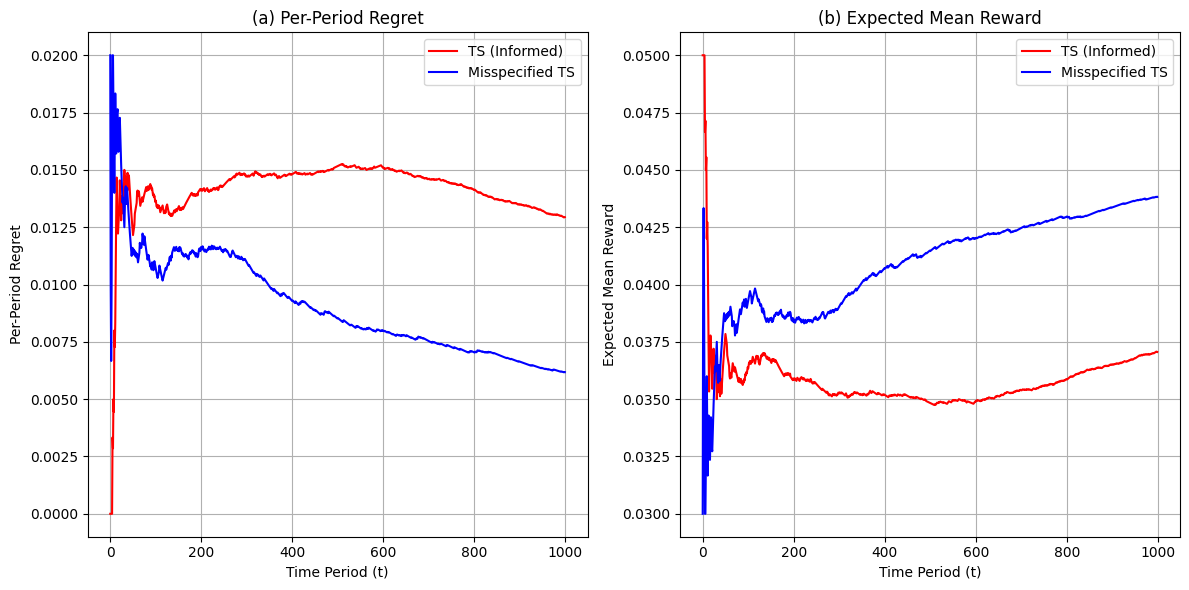

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Simulation Parameters
n_arms = 3  # Number of arms
time_steps = 1000  # Number of time steps
true_means = [0.05, 0.03, 0.01]  # True means of the arms (ground truth)

# Priors
informative_priors = [(1, 20), (1, 33), (1, 99)]  # Informative (correctly specified) priors
uniform_priors = [(1, 1)] * n_arms  # Misspecified (uniform) priors

# Thompson Sampling Function
def thompson_sampling(priors, true_means, time_steps):
    n_arms = len(true_means)
    successes = np.zeros(n_arms)
    failures = np.zeros(n_arms)
    regrets = []
    expected_rewards = []

    for t in range(time_steps):
        # Sample theta for each arm
        sampled_theta = [beta.rvs(a + successes[i], b + failures[i]) for i, (a, b) in enumerate(priors)]
        chosen_arm = np.argmax(sampled_theta)  # Choose the arm with the highest sampled theta

        # Simulate the reward
        reward = np.random.rand() < true_means[chosen_arm]

        # Update successes and failures
        if reward:
            successes[chosen_arm] += 1
        else:
            failures[chosen_arm] += 1

        # Compute regret and expected reward
        best_mean = max(true_means)
        regret = best_mean - true_means[chosen_arm]
        regrets.append(regret)
        expected_rewards.append(true_means[chosen_arm])

    # Return cumulative regret and mean rewards
    cumulative_regret = np.cumsum(regrets)
    mean_rewards = np.cumsum(expected_rewards) / np.arange(1, time_steps + 1)
    return cumulative_regret, mean_rewards

# Run Thompson Sampling for both priors
regret_informed, reward_informed = thompson_sampling(informative_priors, true_means, time_steps)
regret_uniform, reward_uniform = thompson_sampling(uniform_priors, true_means, time_steps)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Regret
plt.subplot(1, 2, 1)
plt.plot(regret_informed / np.arange(1, time_steps + 1), label="TS (Informed)", color="red")
plt.plot(regret_uniform / np.arange(1, time_steps + 1), label="Misspecified TS", color="blue")
plt.xlabel("Time Period (t)")
plt.ylabel("Per-Period Regret")
plt.title("(a) Per-Period Regret")
plt.legend()
plt.grid(True)

# Plot Expected Mean Reward
plt.subplot(1, 2, 2)
plt.plot(reward_informed, label="TS (Informed)", color="red")
plt.plot(reward_uniform, label="Misspecified TS", color="blue")
plt.xlabel("Time Period (t)")
plt.ylabel("Expected Mean Reward")
plt.title("(b) Expected Mean Reward")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

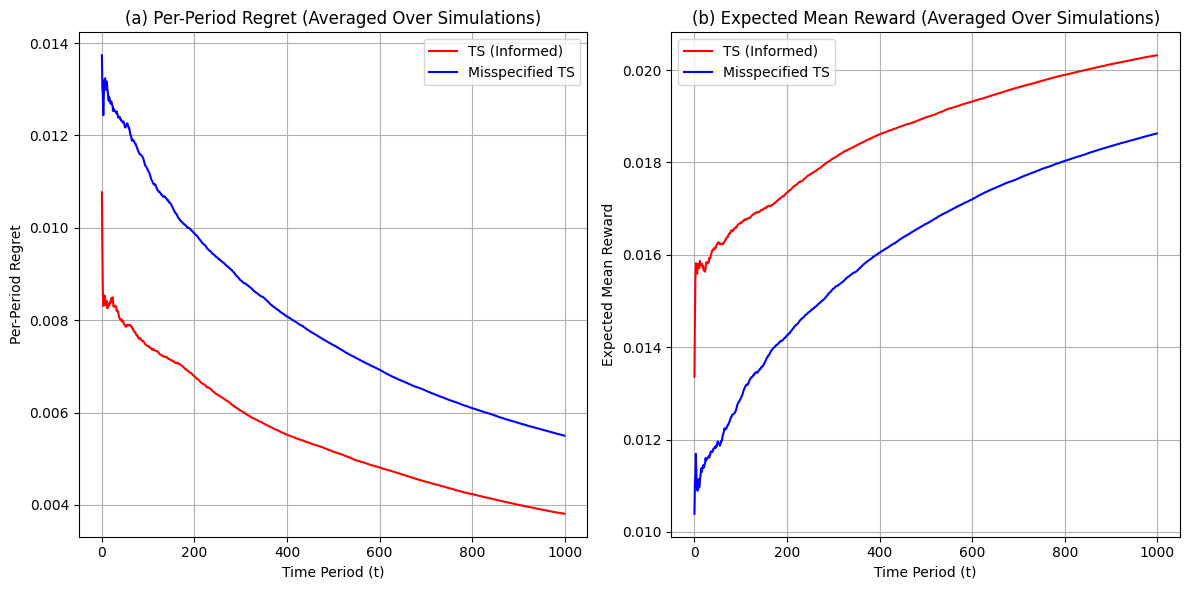

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Parameters
n_simulations = 100  # Number of independent simulations
n_arms = 3             # Number of arms
time_steps = 1000      # Number of time steps
true_prior_params = [(1, 50), (1, 100), (1, 200)]  # Beta distributions for true CTRs
informative_priors = [(1, 20), (1, 33), (1, 99)]  # Informed priors
uniform_priors = [(1, 1)] * n_arms  # Uniform priors

# Function to run Thompson Sampling
def thompson_sampling(priors, true_means, time_steps):
    n_arms = len(true_means)
    successes = np.zeros(n_arms)
    failures = np.zeros(n_arms)
    regrets = []
    expected_rewards = []

    for t in range(time_steps):
        # Sample theta for each arm
        sampled_theta = [beta.rvs(a + successes[i], b + failures[i]) for i, (a, b) in enumerate(priors)]
        chosen_arm = np.argmax(sampled_theta)

        # Simulate reward
        reward = np.random.rand() < true_means[chosen_arm]

        # Update successes and failures
        if reward:
            successes[chosen_arm] += 1
        else:
            failures[chosen_arm] += 1

        # Calculate regret and expected reward
        best_mean = max(true_means)
        regret = best_mean - true_means[chosen_arm]
        regrets.append(regret)
        expected_rewards.append(true_means[chosen_arm])

    return regrets, expected_rewards

# Perform simulations
cumulative_regret_informed = np.zeros(time_steps)
cumulative_regret_uniform = np.zeros(time_steps)
mean_reward_informed = np.zeros(time_steps)
mean_reward_uniform = np.zeros(time_steps)

for sim in range(n_simulations):
    # Sample true means for each arm
    true_means = [beta.rvs(a, b) for a, b in true_prior_params]

    # Run TS with informed priors
    regret_inf, reward_inf = thompson_sampling(informative_priors, true_means, time_steps)
    cumulative_regret_informed += np.cumsum(regret_inf)
    mean_reward_informed += np.cumsum(reward_inf) / np.arange(1, time_steps + 1)

    # Run TS with uniform priors
    regret_uni, reward_uni = thompson_sampling(uniform_priors, true_means, time_steps)
    cumulative_regret_uniform += np.cumsum(regret_uni)
    mean_reward_uniform += np.cumsum(reward_uni) / np.arange(1, time_steps + 1)

# Average results over all simulations
cumulative_regret_informed /= n_simulations
cumulative_regret_uniform /= n_simulations
mean_reward_informed /= n_simulations
mean_reward_uniform /= n_simulations

# Plotting
plt.figure(figsize=(12, 6))

# Plot Per-Period Regret
plt.subplot(1, 2, 1)
plt.plot(cumulative_regret_informed / np.arange(1, time_steps + 1), label="TS (Informed)", color="red")
plt.plot(cumulative_regret_uniform / np.arange(1, time_steps + 1), label="Misspecified TS", color="blue")
plt.xlabel("Time Period (t)")
plt.ylabel("Per-Period Regret")
plt.title("(a) Per-Period Regret (Averaged Over Simulations)")
plt.legend()
plt.grid(True)

# Plot Expected Mean Reward
plt.subplot(1, 2, 2)
plt.plot(mean_reward_informed, label="TS (Informed)", color="red")
plt.plot(mean_reward_uniform, label="Misspecified TS", color="blue")
plt.xlabel("Time Period (t)")
plt.ylabel("Expected Mean Reward")
plt.title("(b) Expected Mean Reward (Averaged Over Simulations)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
print("True CTRs:", true_means)
print("Informed Priors (alpha, beta):", informative_priors)
print("Uniform Priors (alpha, beta):", uniform_priors)


True CTRs: [0.05, 0.03, 0.01]
Informed Priors (alpha, beta): [(1, 20), (1, 33), (1, 99)]
Uniform Priors (alpha, beta): [(1, 1), (1, 1), (1, 1)]


In [8]:
def arm_selection_frequency(priors, true_means, time_steps):
    n_arms = len(true_means)
    successes = np.zeros(n_arms)
    failures = np.zeros(n_arms)
    selection_count = np.zeros(n_arms)

    for t in range(time_steps):
        # Sample from Beta for each arm
        sampled_theta = [beta.rvs(a + successes[i], b + failures[i]) for i, (a, b) in enumerate(priors)]
        chosen_arm = np.argmax(sampled_theta)

        # Update selection count
        selection_count[chosen_arm] += 1

        # Simulate reward
        reward = np.random.rand() < true_means[chosen_arm]

        # Update successes and failures
        if reward:
            successes[chosen_arm] += 1
        else:
            failures[chosen_arm] += 1

    return selection_count

# Track arm selection
selection_informed = arm_selection_frequency(informative_priors, true_means, time_steps)
selection_uniform = arm_selection_frequency(uniform_priors, true_means, time_steps)

print("Arm Selection Count (Informed Priors):", selection_informed)
print("Arm Selection Count (Uniform Priors):", selection_uniform)

Arm Selection Count (Informed Priors): [759. 216.  25.]
Arm Selection Count (Uniform Priors): [807. 111.  82.]


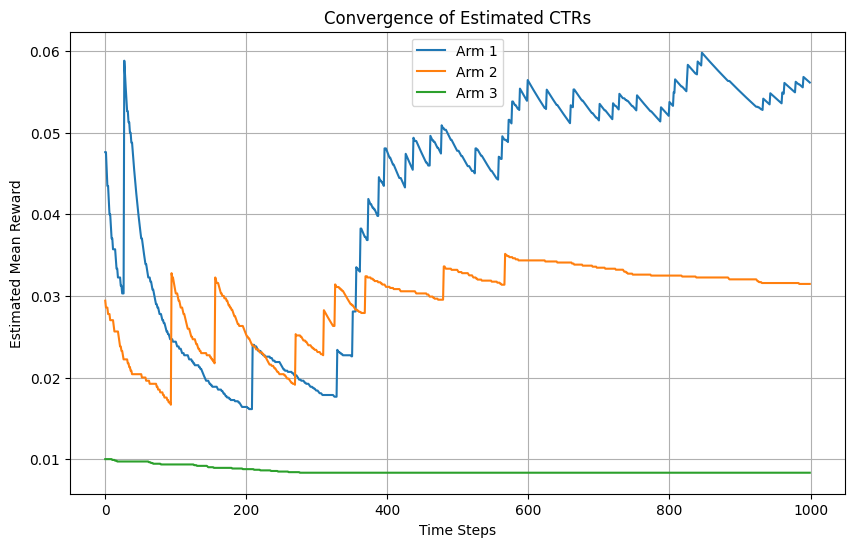

In [9]:
def plot_reward_convergence(priors, true_means, time_steps):
    n_arms = len(true_means)
    successes = np.zeros(n_arms)
    failures = np.zeros(n_arms)
    estimated_means = np.zeros((time_steps, n_arms))

    for t in range(time_steps):
        for arm in range(n_arms):
            estimated_means[t, arm] = (successes[arm] + priors[arm][0]) / (successes[arm] + failures[arm] + priors[arm][0] + priors[arm][1])

        # Sample and update
        sampled_theta = [beta.rvs(a + successes[i], b + failures[i]) for i, (a, b) in enumerate(priors)]
        chosen_arm = np.argmax(sampled_theta)
        reward = np.random.rand() < true_means[chosen_arm]

        if reward:
            successes[chosen_arm] += 1
        else:
            failures[chosen_arm] += 1

    # Plot
    plt.figure(figsize=(10, 6))
    for arm in range(n_arms):
        plt.plot(estimated_means[:, arm], label=f"Arm {arm+1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Estimated Mean Reward")
    plt.title("Convergence of Estimated CTRs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize reward convergence for informed priors
plot_reward_convergence(informative_priors, true_means, time_steps)

In [19]:
# Function to simulate Thompson Sampling and track rewards per arm
def simulate_ts_rewards_per_arm(priors, true_means, time_steps):
    n_arms = len(true_means)
    successes = np.zeros(n_arms)
    failures = np.zeros(n_arms)
    rewards_per_arm = np.zeros((time_steps, n_arms))  # Track rewards for each arm

    for t in range(time_steps):
        # Sample theta for each arm
        sampled_theta = [beta.rvs(a + successes[i], b + failures[i]) for i, (a, b) in enumerate(priors)]
        chosen_arm = np.argmax(sampled_theta)

        # Simulate reward
        reward = np.random.rand() < true_means[chosen_arm]

        # Update successes and failures
        if reward:
            successes[chosen_arm] += 1
        else:
            failures[chosen_arm] += 1

        # Update rewards per arm
        for arm in range(n_arms):
            rewards_per_arm[t, arm] = true_means[arm]

    return rewards_per_arm

# Run simulations and track rewards per arm
avg_rewards_per_arm_informed = np.zeros((time_steps, n_arms))
avg_rewards_per_arm_uniform = np.zeros((time_steps, n_arms))

for _ in range(n_simulations):
    # Sample true CTRs for this simulation
    true_means = [beta.rvs(a, b) for a, b in true_reward_distributions]

    # Simulate TS with informed priors
    rewards_inf = simulate_ts_rewards_per_arm(informative_priors, true_means, time_steps)
    avg_rewards_per_arm_informed += rewards_inf

    # Simulate TS with uniform priors
    rewards_unif = simulate_ts_rewards_per_arm(uniform_priors, true_means, time_steps)
    avg_rewards_per_arm_uniform += rewards_unif

# Average results over all simulations
avg_rewards_per_arm_informed /= n_simulations
avg_rewards_per_arm_uniform /= n_simulations

# Sort arms by true reward ranking
sorted_indices = np.argsort(true_means)[::-1]  # Best to worst

# Plot results
plt.figure(figsize=(12, 6))

# Plot Expected Mean Reward for Informed TS
plt.subplot(1, 2, 1)
plt.plot(avg_rewards_per_arm_informed[:, sorted_indices[0]], label="Best Arm", color="red")
plt.plot(avg_rewards_per_arm_informed[:, sorted_indices[1]], label="Second-Best Arm", color="orange")
plt.plot(avg_rewards_per_arm_informed[:, sorted_indices[2]], label="Worst Arm", color="pink")
plt.xlabel("Time Period (t)")
plt.ylabel("Expected Mean Reward")
plt.title("TS (Informed)")
plt.legend()
plt.grid(True)

# Plot Expected Mean Reward for Uniform TS
plt.subplot(1, 2, 2)
plt.plot(avg_rewards_per_arm_uniform[:, sorted_indices[0]], label="Best Arm", color="blue")
plt.plot(avg_rewards_per_arm_uniform[:, sorted_indices[1]], label="Second-Best Arm", color="green")
plt.plot(avg_rewards_per_arm_uniform[:, sorted_indices[2]], label="Worst Arm", color="purple")
plt.xlabel("Time Period (t)")
plt.ylabel("Expected Mean Reward")
plt.title("Misspecified TS")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'true_reward_distributions' is not defined